# Part IV -  ML For Interpersonal Physical Alignment
#####  @ Haim Goldfisher

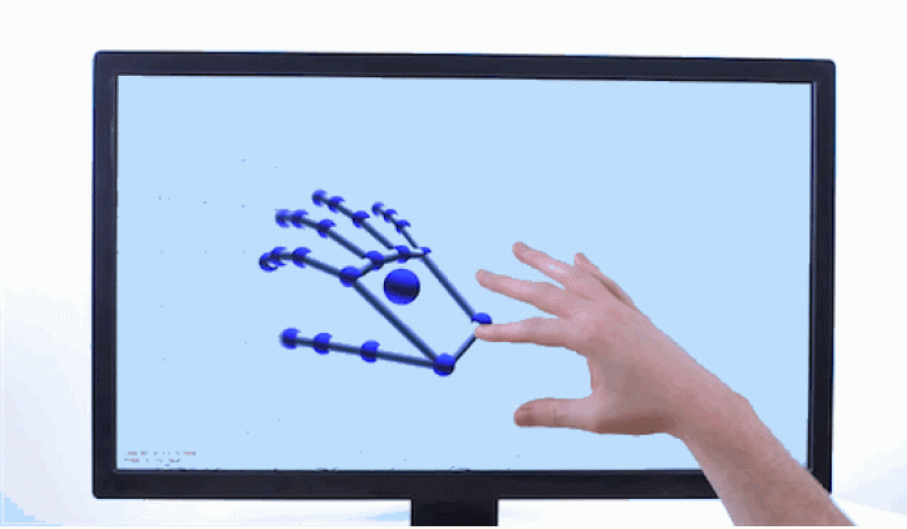

# Libraries Importation:

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings & offline
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as pyo

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score, make_scorer

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Brief Summary:

The purpose of the work is to classify between three different situations in the way people communicate with each other:
- The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other.
- The second is a Synchronous movement in which the two people move their hands together. 
- The third is a movement in position own (Alone). Where only one side moves the hands.

The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous.

The experiment is based on synchronization between two people. That is, they both "transmit on the same wave" so that no one is leading this synchronization. In this case the argument is that there is not one "brain" of the two that leads but two brains of two people uniting into a spring of cooperation that is supposedly above both of them, which controls their movements in the synchronization process.

The experiment uses a system that captures the position of a person's hands. The system knows where the hand is. The experiment places two people facing each other. The experiment operation tells them to move their hands in front of each other spontaneously. He then asks them to be in sync (the process causes both parties to try to be in sync). People begin to perceive each other in order to understand the other side (there must be no imitation of one side, otherwise it does not work). We have three situations: alone, spontaneous in front of another person and in sync with another person.

Assumption of the experiment: The felt state will necessarily be different from the spontaneous state. That is, an experience of looking at another person, the connection between them automatically changes the movement of the two people (as long as they do not have autism). Also, the distance between the two people should be taken into account, because a person alone will move freely when there is no person next to him that he can hurt. In contrast, people who stand relatively close will inevitably move in more measured movements so as not to accidentally hurt each other.

Note, the literature defines synchronization as a product of a velocity vector. When people are in sync, they have the same velocity vector. The above experiment examines the definition of synchronization as the location of the two entities to each other at a given time.

##### Documentation: https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html

# Datasets & Data Preprocessing:

Following the instructions, I filtered the CSV files before loading them. That is, I removed the unnecessary files so that in each folder only the three relevant files (the last three) would appear. Also, depending on what was required, the first 7 seconds were removed from each CSV file (using pandas method). Moreover, I took four timestamps from each second (4/60).

In [2]:
# inner fuction to add HandRight to 'Alone's files, and fit their 'Time' & 'Frame ID' values into left's values

def alone_handright(dataframe):
    
    df = dataframe.copy()
    df = df[df[' Hand Type']=='left'] # drop right from alone
    df.reset_index(drop=True, inplace=True) # reset to index after dropping some of the rows
    right = pd.read_csv(r'C:\Haim\Anaconda\Experiment\HandRight.csv') # upload HandRight CSV
    right = right[right['Time'] > right['Time'].min()+7] # the 7 first second are being removed (just like left)
    right.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) # drop rows with null values
    right = pd.concat([right, right], axis=0) # double right so it will be always bigger than alone
    min_len = min(len(right), len(df)) # we want to merge each left with right, their amount must be the same
    df, right = df[:min_len], right[:min_len] # resize each df into the min amount of rows
    right.drop(['Time', ' Frame ID'], axis=1, inplace=True) # we will add left
    right['Time'] = list(df['Time']) # right's time becomes left's time
    right[' Frame ID'] = list(df[' Frame ID']) # right's frame id becomes left's frame id
    df = pd.concat([right, df], axis=0).sort_index() # concat left & right into one df
    return df

In [3]:
# inner function to perform the required changes on the data

def pandas_preprocessing(dataframe):
    df = dataframe.copy()
    left = df.loc[df[' Hand Type']=='left'] # create df of only left
    right = df.loc[df[' Hand Type']=='right'] # create df of only right
    df = pd.merge(left, right, how='outer', on=['Time', ' Frame ID', ' # hands']) # merge them on equal features
    # this merge fuction created new feqtures for right hand so both hands are in the same row
    df.drop([' Hand Type_x', ' Hand Type_y', ' # hands'], axis=1, inplace=True) # drop useless columns
    df.dropna(axis = 0, inplace=True, how="any") # for left which has no right or the opposite case
    df = df[df.index % 15 == 0] # every second has 60 timestamps, 60 % 15 = 4 ---> timestamps per second 
    return df
    

In [4]:
# this main function gets a folder name (Train or Validation) and create a df from all csv file the folder has

def upload(PATH):
    folders = glob.glob(path + "/*") # the folder of all folders
    data = [] # output list
    labels = ["Alone", "Spontan", "Sync"] # all options
    for folder_name in folders: # run over the folders
        files = glob.glob(folder_name + "/*.csv") # the csv files
        for filename in files: # run over each csv in the folder
            df = pd.read_csv(filename, index_col=None, header=0) # read the currect csv file
            df = df[df['Time'] > df['Time'].min()+7] # the 7 first second are being removed
            for label in labels: # it checks which one of the 3 labels this csv is
                if label in filename: # for adding the correct label to the correct df
                    if label == 'Alone': # unique function for alone case
                        df = alone_handright(df) # add hand right to the csv
                    if "Train"  in folder_name: # for Train upload:
                        experimenter = folder_name.split('g')[1][1:] # for train df
                    else: # for Test upload:
                        experimenter = folder_name.split('n')[4][1:] # for validation df
                    df = pandas_preprocessing(df) # do the required changes on the df
                    df["Label"] = label # new feature with the label name
                    df["Name"] = experimenter # new feature with the experimenter name                     
            data.append(df) # add the new df to the list
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [5]:
PATH = "C:\Haim\Anaconda\Experiment\Training"
df_train = upload(PATH)

In [6]:
df_train.head(3)

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label,Name
0,343.0061,129364,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.47991,1.423625,0.510471,...,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752,Spontan,Evyatar Cohen
1,343.2546,129392,-113.7012,265.1228,-18.019300,-29.71481,232.7269,-112.08070,1.487226,0.126440,...,202.8605,-7.007293,363.4305,98.06007,159.4749,0.171141,1.188835,0.000000,Spontan,Evyatar Cohen
2,343.5033,129421,-110.8198,241.6360,-37.708420,110.78850,-538.5549,111.40300,1.073398,0.286429,...,219.3940,-6.981508,342.5419,169.47190,195.1056,0.118825,1.105556,0.000000,Spontan,Evyatar Cohen


In [7]:
df_train.shape

(6736, 40)

In [8]:
# groupby by each label

df_train.groupby('Label').count()

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Name
Label,,,,,,,,,,,,,,,,,,,,,
Alone,2180,2180,2180,2180,2180,2180,2180,2180,2180,2180,...,2180,2180,2180,2180,2180,2180,2180,2180,2180,2180
Spontan,2282,2282,2282,2282,2282,2282,2282,2282,2282,2282,...,2282,2282,2282,2282,2282,2282,2282,2282,2282,2282
Sync,2274,2274,2274,2274,2274,2274,2274,2274,2274,2274,...,2274,2274,2274,2274,2274,2274,2274,2274,2274,2274


In [9]:
# groupby by each experimenter's name

df_train.groupby('Name').count()

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
Name,,,,,,,,,,,,,,,,,,,,,
Evyatar Cohen,812,812,812,812,812,812,812,812,812,812,...,812,812,812,812,812,812,812,812,812,812
Nofar Social_Nuero,806,806,806,806,806,806,806,806,806,806,...,806,806,806,806,806,806,806,806,806,806
Oriya Social_Nuero,805,805,805,805,805,805,805,805,805,805,...,805,805,805,805,805,805,805,805,805,805
Orya Kalmanovitz,809,809,809,809,809,809,809,809,809,809,...,809,809,809,809,809,809,809,809,809,809
Revital Marbel,750,750,750,750,750,750,750,750,750,750,...,750,750,750,750,750,750,750,750,750,750
Shahar Terner,812,812,812,812,812,812,812,812,812,812,...,812,812,812,812,812,812,812,812,812,812
Shelly Social_Nuero,778,778,778,778,778,778,778,778,778,778,...,778,778,778,778,778,778,778,778,778,778
Yael Ha,772,772,772,772,772,772,772,772,772,772,...,772,772,772,772,772,772,772,772,772,772
Yoel Raz,392,392,392,392,392,392,392,392,392,392,...,392,392,392,392,392,392,392,392,392,392


In [10]:
# uploading our test df

PATH = "C:\Haim\Anaconda\Experiment\Validation"
df_test = upload(PATH)

In [11]:
df_test.shape

(1985, 40)

In [12]:
# we will map our labels & Names into numbers:

mapping = {'Alone':0, 'Spontan':1, 'Sync':2}
df_train.Label = df_train.Label.map(mapping)
df_test.Label = df_test.Label.map(mapping)

encoder = LabelEncoder()
df_train['Name'] = encoder.fit_transform(df_train['Name'])

df_train.head(3)

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label,Name
0,343.0061,129364,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.47991,1.423625,0.510471,...,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752,1,0
1,343.2546,129392,-113.7012,265.1228,-18.019300,-29.71481,232.7269,-112.08070,1.487226,0.126440,...,202.8605,-7.007293,363.4305,98.06007,159.4749,0.171141,1.188835,0.000000,1,0
2,343.5033,129421,-110.8198,241.6360,-37.708420,110.78850,-538.5549,111.40300,1.073398,0.286429,...,219.3940,-6.981508,342.5419,169.47190,195.1056,0.118825,1.105556,0.000000,1,0


In [13]:
# A function to show the labels
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Alone',
    1 :'Spontan',
    2 :'Sync'}
    labeled = label.map(mapping)
    return labeled

##### During my attempts to improve my model, I thought it might be more appropriate to take the last 10 seconds of each experiment and use them as a test for our model (instead of taking the test data randomly). I found that it hurts the results of the model so I gave up on the above idea. This can be explained so that there might be some variability during the experiment. I mean, I guess things happen at the end of the experiment that don't happen at the beginning. Which impairs the model's ability to learn from cases he has not seen. I thought maybe to take some timestamps from the beginning and some timestamps from the end. But then I do not cover the middle case. So I gave up on the idea. Attached here are the two functions I built to organize my test data. I will not use them, but I think it's important that I keep them anyway.

In [14]:
# this function takes the 10 last secound from every experiment and create a validation df from it

def create_val(train_DF):
    data = [] # output, df list
    for i in range (0,9): # i = name (we have 9 names)
        for j in range (0,3): # j = label (we have 3 labels)
            df = train_DF.loc[train_DF["Name"]==i].loc[train_DF["Label"]==j] # name + label
            df.reset_index(drop=True, inplace=True)
            df = df[df['Time'] > df['Time'].max()-10] # take the 10 last second
            df.reset_index(drop=True, inplace=True)
            data.append(df) # add the df to the list
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [15]:
# the train df after the creation on the validation df

def filter_train(train_DF):
    data = [] # output, df list
    for i in range (0,9): # i = name (we have 9 names)
        for j in range (0,3): # j = label (we have 3 labels)
            df = train_DF.loc[train_DF["Name"]==i].loc[train_DF["Label"]==j]
            df.reset_index(drop=True, inplace=True)
            df = df[df['Time'] < df['Time'].max()-10] # get rid of the 10 last second
            df.reset_index(drop=True, inplace=True)
            data.append(df) # add the df to the list
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [16]:
# data\taeget split

target = df_train['Label'] # the feature we would like to predict
data = df_train.drop(['Name','Label',' Frame ID','Time'], axis = 1) # we will drop y from x, because we want to predict it

# Explore The Data:

In [17]:
df_train.isna().sum().sum(), df_test.isna().sum().sum() # no NaN values in df_train & df_test

(0, 0)

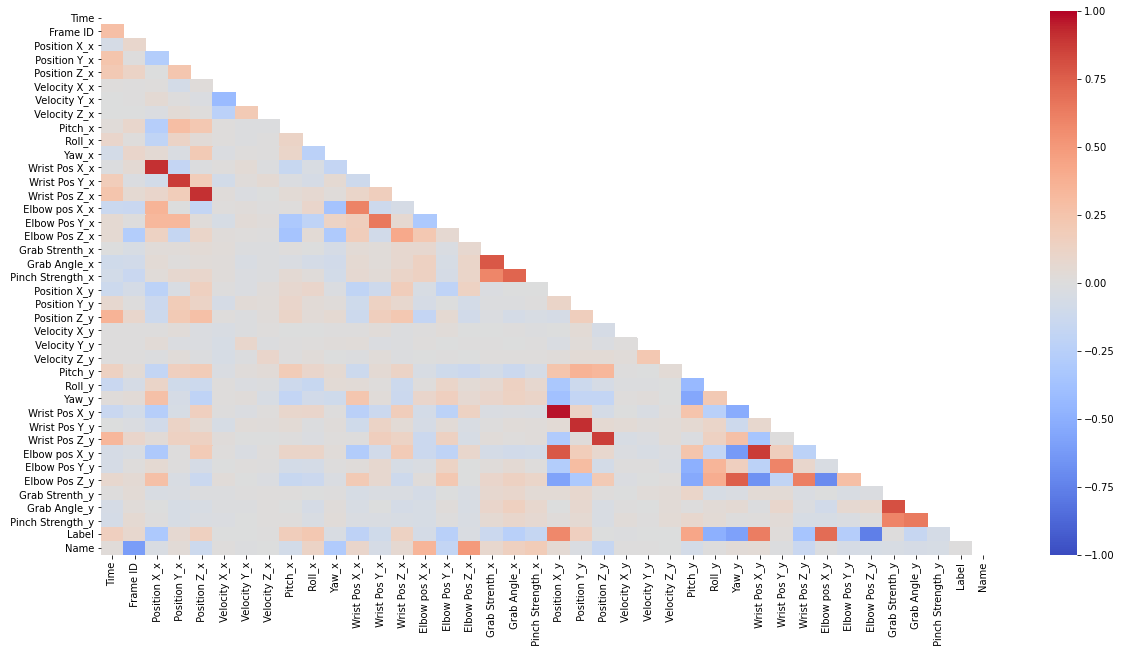

In [18]:
# correalation between each feature by heatmap

plt.figure(figsize=(20, 10))
matrix = np.triu(df_train.corr())
sns.heatmap(df_train.corr(min_periods=0.5), square=False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix);

##### But this correlation map doesnt look so good. We would like to show only relevant values

In [19]:
# correlation with output variable

cor_target = abs(df_train.corr()["Label"])

# selecting highly correlated features

relevant_features = cor_target[cor_target > 0.4]
relevant_features

 Position X_y     0.579272
 Pitch_y          0.435600
 Roll_y           0.492492
 Yaw_y            0.584116
 Wrist Pos X_y    0.629138
 Elbow pos X_y    0.700349
 Elbow Pos Z_y    0.760544
Label             1.000000
Name: Label, dtype: float64

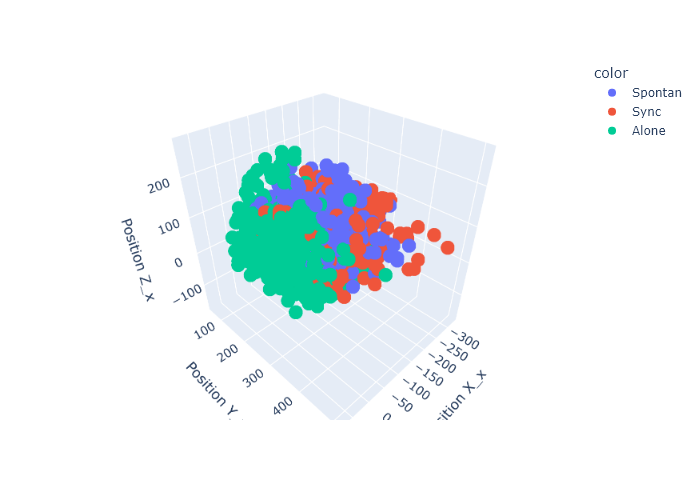

In [20]:
# A 3D graph which represent the distribution of the data by each label name

fig = px.scatter_3d(data, x=' Position X_x', y=' Position Y_x', z=' Position Z_x',
              color=num_to_name(target))
fig.show("png")

In [21]:
# lets take a look at every label from Evyatar's folder

spontan = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771052727603804Spontan.csv')
sync = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771053639929594Sync.csv')
alone = alone_handright(pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771054555711409Alone.csv'))

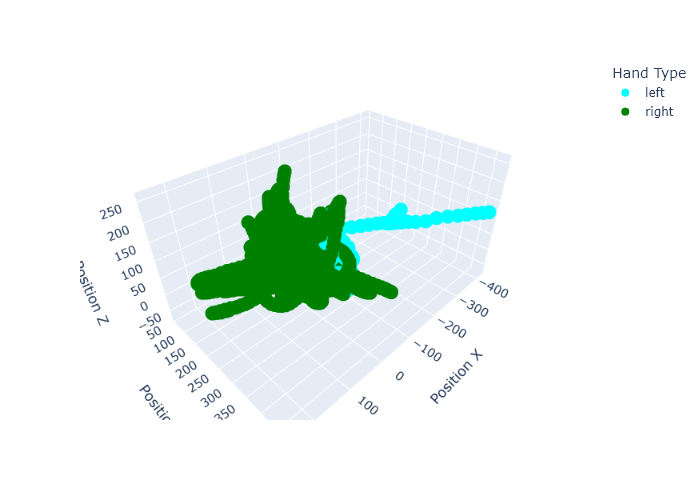

In [22]:
# an example of 'Alone'

fig = px.scatter_3d(alone, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

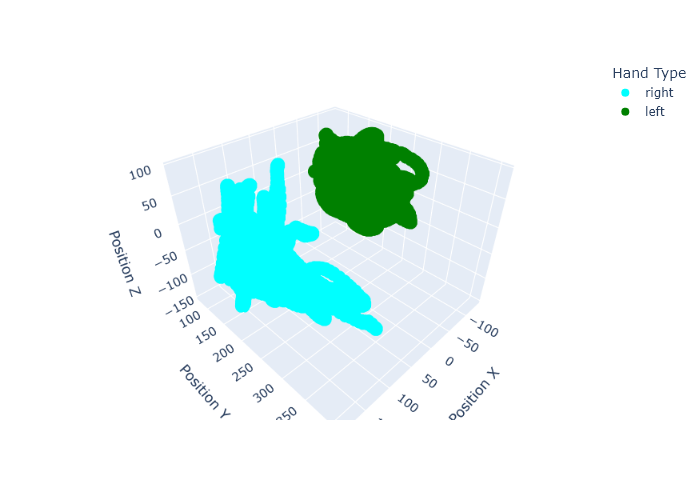

In [23]:
# an example of 'Spontan'

fig = px.scatter_3d(spontan, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

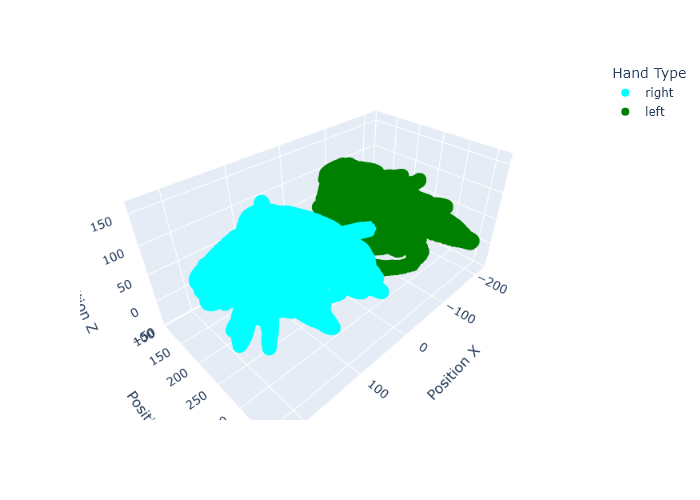

In [24]:
# an example of 'Sync'

fig = px.scatter_3d(sync, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

##### One of the easiest things to notice is that in 'Alone' situation, the two hands intersect because the two people were alone in the room and could move freely. Another thing that is unusually interpreted from the graph is that there is a significant difference between a 'Spontan' situation and a 'Sync' situation. It is clear that classification process should not be too difficult.

##### We would like to take a look at different an experimenter with different features

In [25]:
# according to Revital Marbel folder:

spontan2 = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Revital Marbel\Revital636770957038873193Spontan.csv')
sync2 = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Revital Marbel\Revital636770957894370062Sync.csv')
alone2 = alone_handright(pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Revital Marbel\Revital636770955999435879Alone.csv'))

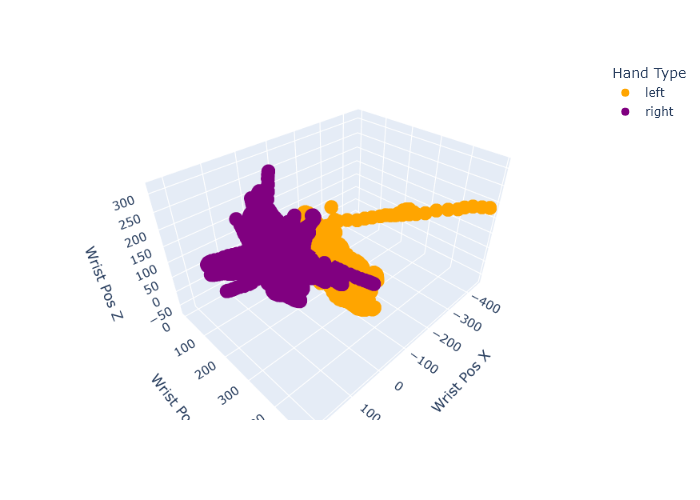

In [26]:
# an example of 'Alone'

fig = px.scatter_3d(alone2, x =' Wrist Pos X', y =' Wrist Pos Y', z =' Wrist Pos Z' ,
                    color=' Hand Type', color_discrete_sequence=["orange", "purple"])
fig.show("png")

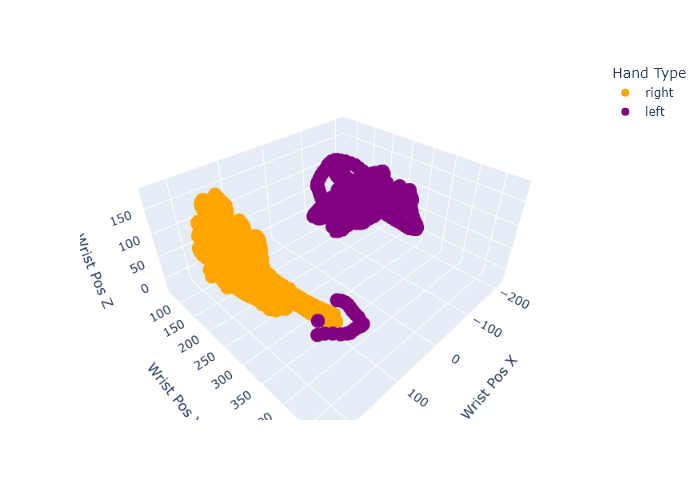

In [27]:
# an example of 'Spontan'

fig = px.scatter_3d(spontan2, x =' Wrist Pos X', y =' Wrist Pos Y', z =' Wrist Pos Z' ,
                    color=' Hand Type', color_discrete_sequence=["orange", "purple"])
fig.show("png")

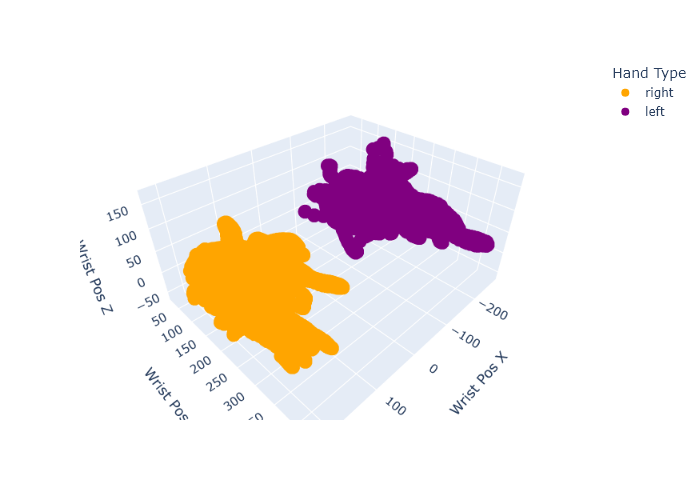

In [28]:
# an example of 'Sync'

fig = px.scatter_3d(sync2, x =' Wrist Pos X', y =' Wrist Pos Y', z =' Wrist Pos Z' ,
                    color=' Hand Type', color_discrete_sequence=["orange", "purple"])
fig.show("png")

##### It is easy to see that in one of the graphs there is a strange jump of wrist position (purple, spontaneous). It indicates that there are also technical faults during the experiment. This may affect the results of our model

# Train / Test Split:

In [29]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=18)

# Scaling:

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Dimensionality Reduction: 
# PCA

In [31]:
pca = PCA()
pca.fit(X_train)

PCA()

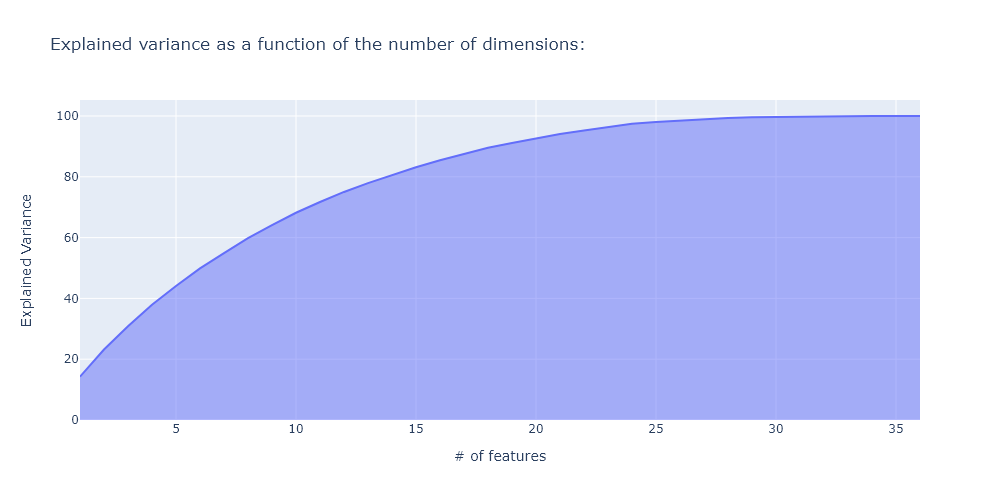

In [32]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    title = "Explained variance as a function of the number of dimensions:",
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul * 100,
    labels={"x": "# of features", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)
fig.show("png")

In [33]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

22

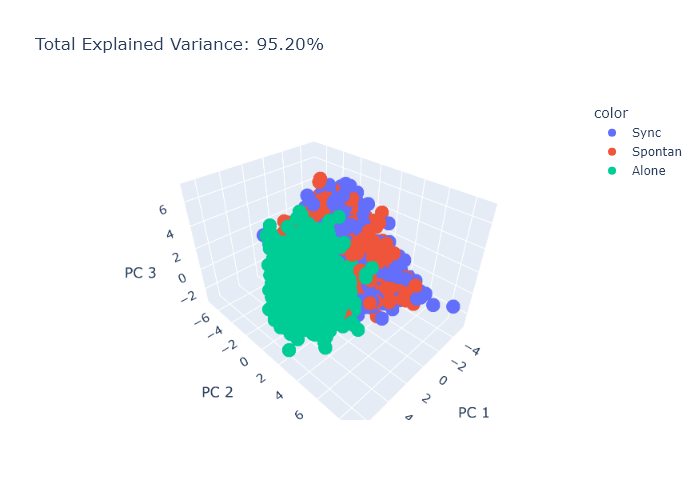

In [34]:
# A three-dimensional graph depicting the way our data is interpreted, plotly does it easily for us 

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    X_train_reduced, x=0, y=1, z=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show("png")

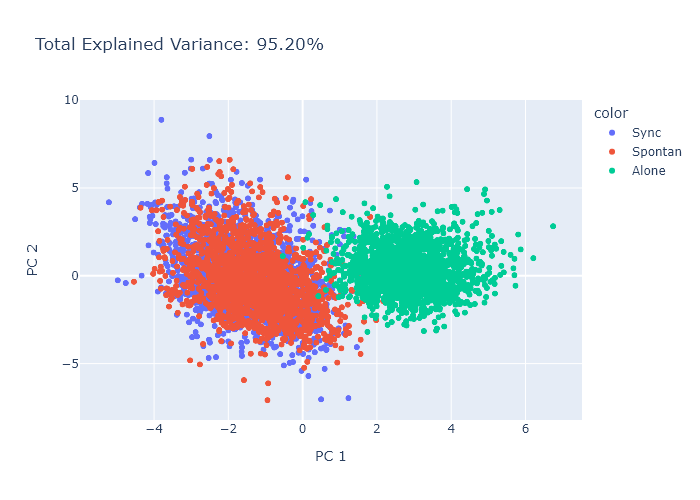

In [35]:
# 2D version: with x and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

##### It is obvious that Alone label is very different from the two other labels. This makes a lot of sense because in Alone situation there is no connection between the two people moving their hands. It can be assumed from this that the main challenge will be to classify between Sync and Spontan.

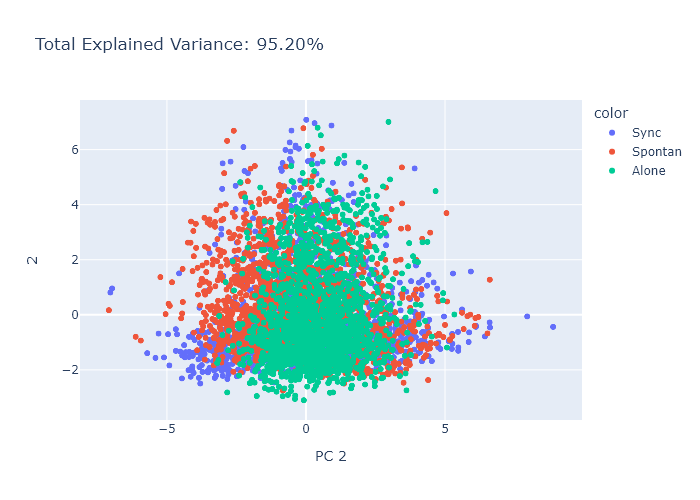

In [36]:
# 2D version: with y and z
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

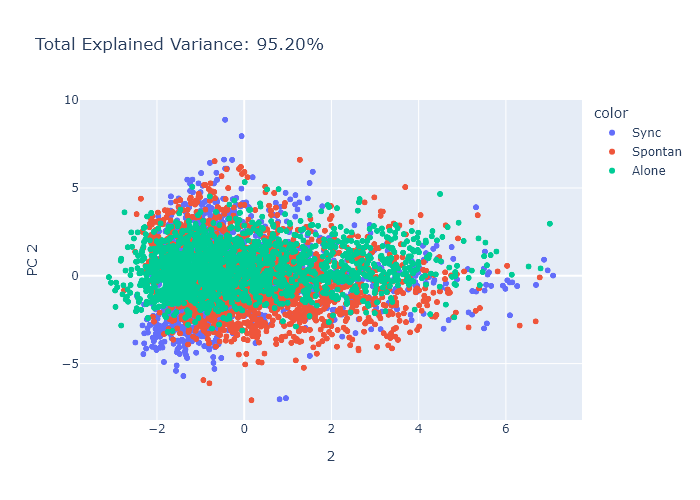

In [37]:
# 2D version: with z and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

In [38]:
X_train = pd.DataFrame(X_train_reduced)
X_val = pd.DataFrame(X_val_reduced)

In [39]:
# we will concat our X,y train & validation for cross validation & grid search

X = pd.concat([X_train, X_val], axis = 0)
y = pd.concat([y_train, y_val], axis = 0)

# Models

## Naive Bayes:

In [40]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes

GaussianNB()

In [41]:
y_pred = bayes.predict(X_val)
bayes_acc = accuracy_score(y_val, y_pred)
bayes_acc

0.8635014836795252

In [42]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       412
           1       0.83      0.79      0.81       465
           2       0.80      0.83      0.82       471

    accuracy                           0.86      1348
   macro avg       0.87      0.87      0.87      1348
weighted avg       0.86      0.86      0.86      1348



## KNN:

In [43]:
knn = KNeighborsClassifier()

In [44]:
# I ran grid search on this model. I hide the code because I already found my best params for KNN.

# Grid search

#k_range = list(range(3,51)) # we will test k values in range 3-50
#weight_op = ['uniform', 'distance'] # we will test the knn methods uniform & distance
#d = {'n_neighbors' :k_range, 'weights': weight_op}
#grid_temp = GridSearchCV(knn, d, cv=cv_split, scoring='accuracy') # we chose model, d(range, methods), num of cv groups and scoring method
#grid_temp.fit(X, y)
#print("score:",grid_temp.best_score_," params:",grid_temp.best_params_)

In [45]:
knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn.fit(X_train, y_train)
knn

y_pred = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred)
knn_acc

0.9473293768545994

In [46]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       412
           1       0.92      0.93      0.93       465
           2       0.92      0.93      0.93       471

    accuracy                           0.95      1348
   macro avg       0.95      0.95      0.95      1348
weighted avg       0.95      0.95      0.95      1348



## Logistic Regression:

In [47]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr

LogisticRegression()

In [48]:
y_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val, y_pred)
lr_acc

0.862759643916914

In [49]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       412
           1       0.81      0.80      0.81       465
           2       0.81      0.81      0.81       471

    accuracy                           0.86      1348
   macro avg       0.87      0.87      0.87      1348
weighted avg       0.86      0.86      0.86      1348



## CatBoost:

In [50]:
cat = CatBoostClassifier(logging_level='Silent', random_state=8)
cat.fit(X_train, y_train)
cat

In [51]:
y_pred = cat.predict(X_val)
y_pred_cat = y_pred.copy()
cat_acc = accuracy_score(y_val, y_pred)
cat_acc

0.9540059347181009

In [52]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       412
           1       0.92      0.95      0.94       465
           2       0.95      0.92      0.94       471

    accuracy                           0.95      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.95      0.95      0.95      1348



## AdaBoost:

In [53]:
rfc = RandomForestClassifier(n_estimators=10, random_state=18)
ada = AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc, random_state=18)
ada.fit(X_train, y_train)
ada

AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10,
                                                         random_state=18),
                   learning_rate=0.1, n_estimators=100, random_state=18)

In [54]:
y_pred = ada.predict(X_val)
ada_acc = accuracy_score(y_val, y_pred)
ada_acc

0.9413946587537092

In [55]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       412
           1       0.91      0.92      0.92       465
           2       0.93      0.91      0.92       471

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



## Gradient Boosting:

In [56]:
gb = GradientBoostingClassifier(random_state=18)
gb.fit(X_train, y_train)
gb

GradientBoostingClassifier(random_state=18)

In [57]:
y_pred = gb.predict(X_val)
gb_acc = accuracy_score(y_val, y_pred)
gb_acc

0.9072700296735905

In [58]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       412
           1       0.86      0.88      0.87       465
           2       0.88      0.86      0.87       471

    accuracy                           0.91      1348
   macro avg       0.91      0.91      0.91      1348
weighted avg       0.91      0.91      0.91      1348



## XGBoosting:

In [59]:
xgb = XGBClassifier(use_label_encoder =False)

In [60]:
# Since I already used grid search, we will hide the code, because we have the params we need for XGB

#params = {"learning_rate"    : [0.05, 0.15, 0.20, 0.30] ,
#          "max_depth"        : [3, 5, 8, 10, 15],
#          "min_child_weight" : [3, 5, 7 ],
#          "gamma"            : [0.0, 0.1, 0.2 , 0.4],
#          "colsample_bytree" : [0.3, 0.5 , 0.7] }

#grid_search = GridSearchCV(xgb, param_grid = params, cv = 4, verbose = 1)
#grid_search.fit(X, y)
#print("score:",grid_search.best_score_," params:",grid_search.best_params_)

In [61]:
#xgb = XGBClassifier(max_depth=10,min_child_weight=5,gamma=0.1,colsample_bytree=0.7) my defult params are better
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred)
xgb_acc

[12:47:24] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9399109792284867

In [62]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       412
           1       0.91      0.92      0.92       465
           2       0.92      0.91      0.92       471

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



## Random Forest:

In [63]:
rf = RandomForestClassifier(random_state=18)

In [64]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],

#'n_estimators': [100, 200, 300]
#}

#grid_search = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = 1)
#grid_search.fit(X, y)
#print("score:",grid_search.best_score_," params:",grid_search.best_params_)

In [65]:
rf = RandomForestClassifier(bootstrap= True, max_depth= 80, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 200, random_state=18)

rf.fit(X_train, y_train)
rf

y_pred = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc

0.9176557863501483

In [66]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       412
           1       0.88      0.91      0.89       465
           2       0.90      0.87      0.89       471

    accuracy                           0.92      1348
   macro avg       0.92      0.92      0.92      1348
weighted avg       0.92      0.92      0.92      1348



In [67]:
stacking = StackingClassifier(estimators=[('cat',cat),('knn',knn)],final_estimator=knn)
stacking.fit(X_train,y_train)
stacking

StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002F424AC0D30>),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=4,
                                                     weights='distance'))],
                   final_estimator=KNeighborsClassifier(n_neighbors=4,
                                                        weights='distance'))

In [68]:
y_pred = stacking.predict(X_val)
y_pred_stack = y_pred
stacking_acc = accuracy_score(y_val, y_pred)
stacking_acc

0.9554896142433235

In [69]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       412
           1       0.92      0.96      0.94       465
           2       0.96      0.92      0.94       471

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



## Voting:

##### In general, it is good to choose the Soft Voting model istead of Hard voting model, because it relates to the level of certainty of each model. That is, if Catboost & Adaboost are not so sure in the specific label they chose but the KNN model is sure about other label more than the others, we will go by KNN choise. Also, I gave more weight to the Catboost and KNN models over Adaboost (2:2:1) because they had better results than him. Also, Adaboost and Catboost are models that rely on decision trees (gradient boosting algorithms). Unlike KNN which works with a completely different strategy. That's why I prefer not to give to both Catboost & Adaboost such great weight, but to give to Catboost the same weight as KNN.

In [70]:
sv = VotingClassifier(estimators=[
        ('cat', cat), ('knn', knn), ('ada',ada)], voting='soft', weights=[2,2,1])
sv.fit(X_train, y_train)
sv

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002F424AC0D30>),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('ada',
                              AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10,
                                                                                       random_state=18),
                                                 learning_rate=0.1,
                                                 n_estimators=100,
                                                 random_state=18))],
                 voting='soft', weights=[2, 2, 1])

In [71]:
y_pred = sv.predict(X_val)
y_pred_sv = y_pred
sv_acc = accuracy_score(y_val, y_pred)
sv_acc

0.9629080118694362

In [72]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       0.94      0.96      0.95       465
           2       0.96      0.93      0.95       471

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



# Conclusion

In [73]:
acc_list = {'Model':  ['Naive Bayes', 'KNN','Logistic Regression','CatBoost', 'AdaBoost', 'Gradient Boosting', 'XGBoost','Random Forest','Stacking', 'Soft Voting'],
        'Accuracy': [bayes_acc,knn_acc,lr_acc,cat_acc,ada_acc,gb_acc,xgb_acc,rf_acc,stacking_acc,sv_acc],
        }

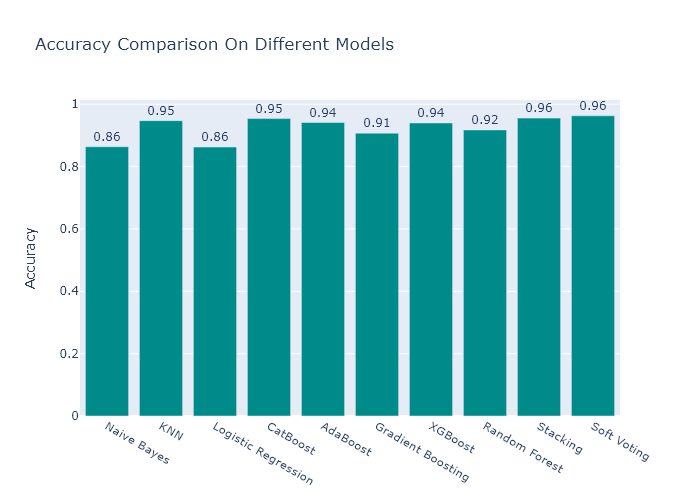

In [74]:
# bar graph as a conclusion to the models
fig = go.Figure(data=[
    go.Bar(name='train set', x=acc_list['Model'], y=acc_list['Accuracy'],text=np.round(acc_list['Accuracy'],2),textposition='outside',marker_color='darkcyan'),
])
fig.update_layout(barmode='group',title_text='Accuracy Comparison On Different Models',yaxis=dict(
        title='Accuracy'))
fig.show("png")

#### As can be seen, Voting model was the most successful model

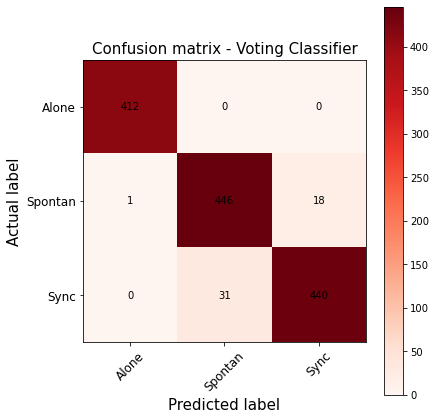

In [75]:
# we would like to present confusion matrix for our best model:

cm = confusion_matrix(y_val, y_pred_sv)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds)
plt.title('Confusion matrix - Voting Classifier', size = 15)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Alone','Spontan','Sync'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Alone','Spontan','Sync'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

#### It turns out that Soft Voting model is the most successful model of all models. We will use it on the test.

# Test

In [76]:
y_test = df_test['Label'] # the feature we would like to predict
X_test = df_test.drop(['Label',' Frame ID','Name','Time'], axis = 1) # we will drop y from x, because we want to predict it

# apply scaling & pca on X_test:

X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

In [77]:
y_pred = sv.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_acc

0.8906801007556675

In [78]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       640
           1       0.79      0.93      0.85       680
           2       0.91      0.75      0.82       665

    accuracy                           0.89      1985
   macro avg       0.90      0.89      0.89      1985
weighted avg       0.90      0.89      0.89      1985



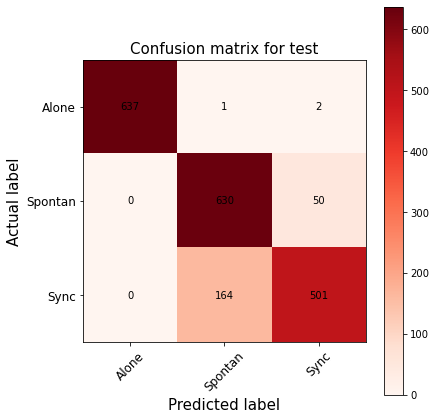

In [79]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds)
plt.title('Confusion matrix for test', size = 15)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Alone','Spontan','Sync'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Alone','Spontan','Sync'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

# To sum up, our Voting model had 89% of success on the Test data. It did it by using 22 of 40 features.